In [1]:
import os


import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
# from unet import build_unet
from tensorflow.keras.metrics import Precision, Recall
 
import random
 

# from metrics import dice_loss, dice_coef
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())

True


In [3]:
print(tf.sysconfig.get_build_info())


OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


In [4]:
import tensorflow as tf

print("GPU in use:", tf.test.gpu_device_name())

GPU in use: /device:GPU:0


In [5]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print(details)

{'device_name': 'NVIDIA GeForce RTX 4050 Laptop GPU', 'compute_capability': (8, 9)}


In [6]:
gpus=tf.config.list_physical_devices('GPU')
if gpus:
    print('GPU available')
else:
    print('GPU not available')
tf.config.list_physical_devices('GPU')

GPU available


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
import tensorflow as tf

# List logical devices (after setting visible devices)
logical_gpus = tf.config.list_logical_devices('GPU')
print("Logical GPUs:", logical_gpus)

Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [8]:
tf.debugging.set_log_device_placement(False)

In [9]:
H = 256
W = 256

In [10]:

# Set a global seed
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [11]:
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# def dice_loss(y_true, y_pred):
#     return 1.0 - dice_coef(y_true, y_pred)
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

In [12]:
# def conv_block(inputs, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     return x


from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def conv_block(x, num_filters, dropout_rate=0.0, reg=1e-4):
    x = Conv2D(
        num_filters,
        3,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=l2(reg)
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)

    x = Conv2D(
        num_filters,
        3,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=l2(reg)
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    return x


def encoder_block(inputs, num_filters, dropout_rate):
    x = conv_block(inputs, num_filters, dropout_rate)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(inputs, skip_features, num_filters, dropout_rate):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, dropout_rate)
    return x

    
# def decoder_block(inputs, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

# def build_unet(input_shape):
#     inputs = Input(input_shape)

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     # print(s1.shape, s2.shape, s3.shape, s4.shape)
#     # print(p1.shape, p2.shape, p3.shape, p4.shape)

#     b1 = conv_block(p4, 1024)

#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

#     model = Model(inputs, outputs, name="UNET")
#     return model
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder (low dropout)
    s1, p1 = encoder_block(inputs, 32, 0.0)
    s2, p2 = encoder_block(p1, 64, 0.1)
    s3, p3 = encoder_block(p2, 128, 0.2)

    # Bottleneck (highest dropout)
    b1 = conv_block(p3, 256, dropout_rate=0.4)

    # Decoder (moderate dropout)
    d1 = decoder_block(b1, s3, 128, 0.2)
    d2 = decoder_block(d1, s2, 64, 0.1)
    d3 = decoder_block(d2, s1, 32, 0.0)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    model = Model(inputs, outputs, name="UNET_Optimized")
    return model


if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "UNET_Optimized"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                    

In [13]:
# def read_mask(path):
#     x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     if x is None:
#         raise ValueError(f"Mask not found or unreadable: {path}")
#     x = cv2.resize(x, (W, H))
#     return x
# print(read_mask("C:\Projects Datasets\Segmentation_1\Segmentation_filtered\\masks"))

In [14]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# def load_dataset(path, split=0.2):
#     images = sorted(glob(os.path.join(path, "images", "*.png")))
#     masks = sorted(glob(os.path.join(path, "masks", "*.png")))

#     split_size = int(len(images) * split)

#     train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
#     train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

#     train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
#     train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

#     return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)
def load_dataset(path, split=0.2, max_samples=None):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks  = sorted(glob(os.path.join(path, "masks", "*.png")))

    assert len(images) == len(masks), "Images and masks count mismatch"

    # 🔹 Limit dataset size
    if max_samples is not None:
        images = images[:max_samples]
        masks  = masks[:max_samples]

    # 🔹 Train / temp split
    train_x, temp_x, train_y, temp_y = train_test_split(
        images, masks,
        test_size=2 * split,
        random_state=42,
        shuffle=True
    )

    # 🔹 Validation / Test split
    valid_x, test_x, valid_y, test_y = train_test_split(
        temp_x, temp_y,
        test_size=0.5,
        random_state=42
    )

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 12
    lr = 1e-4
    num_epochs = 100
    model_path = os.path.join("C:\\Projects Datasets\\model_details\\unet_3", "model_2.h5")
    csv_path = os.path.join("C:\\Projects Datasets\\model_details\\unet_3", "log.csv")

    """ Dataset """
    # dataset_path = "C:\\Projects Datasets\\Segmentation_1\\Segmentation_filtered"
    dataset_path="C:\Projects Datasets\Segmentation_1\Segmentation"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path,0.2,1200)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
    test_dataset  = tf_dataset(test_x, test_y, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    # model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy", dice_coef])
    model.compile( loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy", dice_coef, Precision(name="precision"), Recall(name="recall")] )

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=False),
    ]

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=valid_dataset,
        callbacks=callbacks
    )




Train: 720 - 720
Valid: 240 - 240
Test : 240 - 240
Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 1.2176 - accuracy: 0.8788 - dice_coef: 0.0420 - precision: 0.0452 - recall: 0.4223
Epoch 1: val_loss improved from inf to 1.20995, saving model to C:\Projects Datasets\model_details\unet_3\model_2.h5
60/60 [==============================] - 56s 348ms/step - loss: 1.2176 - accuracy: 0.8788 - dice_coef: 0.0420 - precision: 0.0452 - recall: 0.4223 - val_loss: 1.2099 - val_accuracy: 0.8934 - val_dice_coef: 0.0286 - val_precision: 0.0473 - val_recall: 0.4099 - lr: 1.0000e-04
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 1.1417 - accuracy: 0.8721 - dice_coef: 0.0844 - precision: 0.0751 - recall: 0.7937
Epoch 2: val_loss improved from 1.20995 to 1.18799, saving model to C:\Projects Datasets\model_details\unet_3\model_2.h5
60/60 [==============================] - 21s 343ms/step - loss: 1.1417 - accuracy: 0.8721 - dice_coef: 0.0844 - precision: 0.0751 - 

In [15]:
""" Evaluate on test set """
results = model.evaluate(test_dataset)
print("\nEvaluation Metrics:")
for metric_name, metric_value in zip(model.metrics_names, results):
    print(f"{metric_name}: {metric_value:.4f}")

20/20 [==============================] - 2s 110ms/step - loss: 0.3818 - accuracy: 0.9948 - dice_coef: 0.7738 - precision: 0.9117 - recall: 0.6926

Evaluation Metrics:
loss: 0.3818
accuracy: 0.9948
dice_coef: 0.7738
precision: 0.9117
recall: 0.6926


In [16]:

import pickle
with open("C:\\Projects Datasets\\model_details\\unet_3\\history2.pkl", "wb") as f:
    pickle.dump(history.history, f)


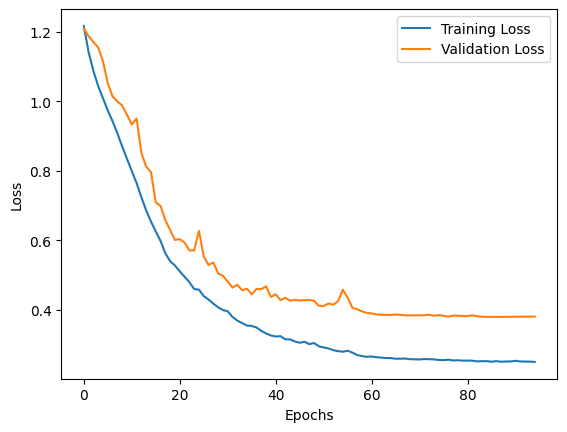

In [17]:
import pickle
import matplotlib.pyplot as plt

with open("C:\\Projects Datasets\\model_details\\unet_3\\history2.pkl", "rb") as f:
    history_dict = pickle.load(f)

plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


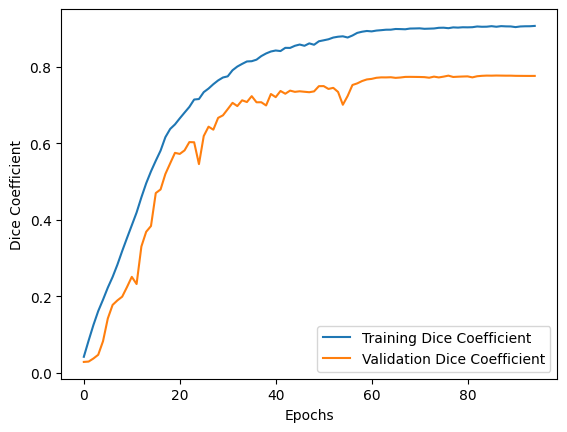

In [18]:
import matplotlib.pyplot as plt

plt.plot(history_dict['dice_coef'], label='Training Dice Coefficient')
plt.plot(history_dict['val_dice_coef'], label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()


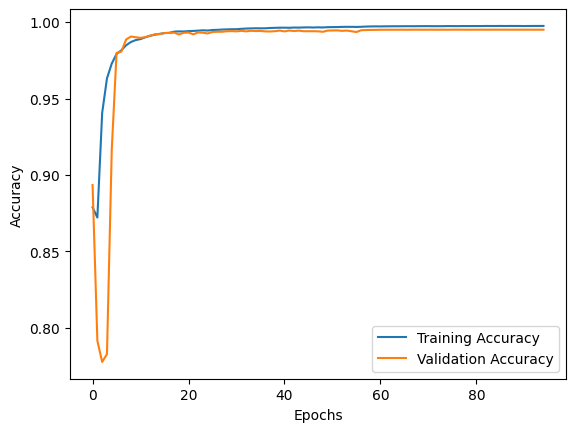

In [19]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
print("Final Training Dice:", history_dict['dice_coef'][-1])
print("Final Validation Dice:", history_dict['val_dice_coef'][-1])
# print(history_dict['accuracy'][-1]



Final Training Dice: 0.9065108895301819
Final Validation Dice: 0.7759190201759338


In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

model = load_model(
    "C:\\Projects Datasets\\model_details\\unet_3\\model_2.h5",
    custom_objects={"dice_coef": dice_coef},
    compile=False
)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",  # or dice_loss
    metrics=["accuracy", dice_coef]
)

loss, accuracy, dice = model.evaluate(test_dataset)

print(f"Loss is {loss}")
print(f"Accuracy is {accuracy}")
print(f"Dice_Coef is {dice}")


20/20 [==============================] - 3s 107ms/step - loss: 0.1901 - accuracy: 0.9948 - dice_coef: 0.7755
Loss is 0.1901051551103592
Accuracy is 0.9948351979255676
Dice_Coef is 0.7754876613616943


In [22]:
!pip install pandas


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV log
csv_path = "C:\\Projects Datasets\\model_details\\unet_3\\log.csv"
log_data = pd.read_csv(csv_path)

# Inspect available columns
print(log_data.columns)


Index(['epoch', 'accuracy', 'dice_coef', 'loss', 'lr', 'precision', 'recall',
       'val_accuracy', 'val_dice_coef', 'val_loss', 'val_precision',
       'val_recall'],
      dtype='object')


In [24]:
#https://github.com/nikhilroxtomar/Brain-Tumor-Segmentation-in-TensorFlow-2.0

In [25]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )


In [26]:
model = load_model("C:\\Projects Datasets\\model_details\\unet_3\\model_2.h5",
                   custom_objects={"dice_coef": dice_coef},
                   compile=False)


In [27]:
import cv2
import numpy as np

# Load image
img_path = "C:\\Projects Datasets\\model_details\\1111.jpg"
image = cv2.imread(img_path)              # BGR format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Resize to model input size
image_resized = cv2.resize(image, (256, 256))

# Normalize to [0,1]
image_norm = image_resized / 255.0

# Add batch dimension
input_tensor = np.expand_dims(image_norm, axis=0)   # shape (1, 256, 256, 3)


In [28]:
pred_mask = model.predict(input_tensor)

# Remove batch dimension
pred_mask = pred_mask[0]

# Threshold (convert probabilities to binary mask)
binary_mask = (pred_mask > 0.5).astype(np.uint8)


1/1 [==============================] - 1s 553ms/step


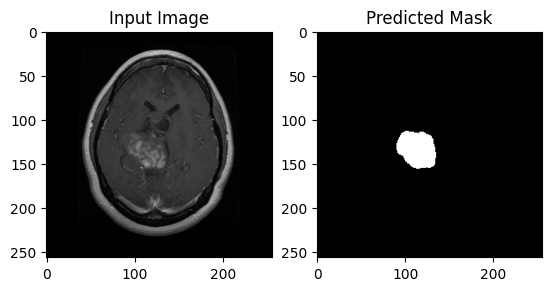

In [29]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(image_resized)
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(binary_mask.squeeze(), cmap="gray")
plt.title("Predicted Mask")

plt.show()
